In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from skimage.transform import rescale

In [100]:
def pad_to(x, size, axis=0):
    n = x.shape[axis]
    dims = len(x.shape)
    pad_list = [(0, 0) for i in range(dims)]
    if n < size:
        # Our input is undersized, so pad with zeros
        padding = size - n
        pad_bef = int(np.floor(padding/2.))
        pad_aft = int(np.ceil(padding/2.))
        pad_list[axis] = (pad_bef, pad_aft)
        return np.pad(x, pad_list, mode='symmetric')

    return x

def catdog_train_generator(data_home='./mldata', out_shape=(128, 128), id_range=(0, 12500), random=True):
    """
        Gets a random selection of cats and dogs to fill the specified
        batch size.
    """
    cat_prefix = '%s/%s' % (data_home, 'kaggle-catdog/train/cat')
    dog_prefix = '%s/%s' % (data_home, 'kaggle-catdog/train/dog')
    is_cat = True
    im_number = id_range[0]
    while 1:
        #--- Create selection ---#
        if random:
            is_cat = bool(np.random.randint(0, 2))
            im_number = np.random.randint(id_range[0], id_range[1])

        #--- Get Image File ---#
        if is_cat:
            im_file = '%s.%s.jpg' % (cat_prefix, str(im_number))
        else:
            im_file = '%s.%s.jpg' % (dog_prefix, str(im_number))

        #--- Read Image File ---#
        im = imread(im_file)
        
        #--- Process Image File ---#
        major_dim = np.argmax(im.shape)
        minor_dim = np.argmin([im.shape[0], im.shape[1]])
        
        scale = out_shape[major_dim] / im.shape[major_dim]
        im = rescale(im, scale, mode='reflect')
        
        # Pad the other dimension 
        im = pad_to(im, out_shape[minor_dim], axis=minor_dim)
        
        #--- Give output ----#
        yield (im, int(is_cat))
        
        #--- Increments for non-random case ---#
        if not random:
            # Increment only after dog, cover both
            if not is_cat:
                im_number += 1 
                if im_number == id_range[1]:
                    break
            # Swap class    
            is_cat = not is_cat

def get_batch(gen, n, data_shape=(64, 64, 3)):
    X = np.empty(np.r_[n, np.asarray(data_shape)])    
    Y = np.empty(n, dtype=int)
    for i in range(n):
        (x, y) = next(gen)
        X[i, :, :, :] = x
        Y[i] = y
        
    return(X,Y)


def batch_generator(gen, batch_size):  
    while 1:
        yield get_batch(gen, batch_size)

In [29]:
gfix = catdog_train_generator(random=False, out_shape=(64,64))

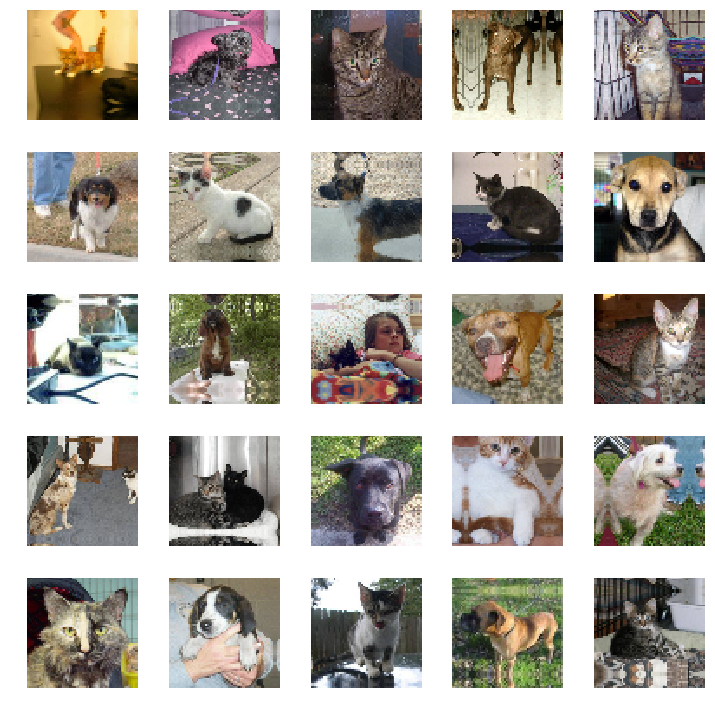

In [30]:
plt_dim = (5,5)

plt.figure(figsize=(10,10))
for i in range(0,plt_dim[0]*plt_dim[1]):
    plt.subplot(plt_dim[0], plt_dim[1], i+1)
    plt.imshow(next(gfix)[0])
    plt.axis('off')

plt.tight_layout()    

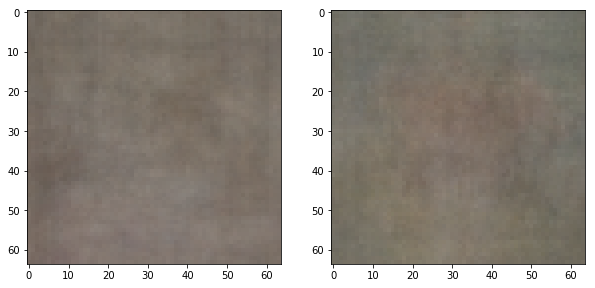

In [31]:
dog_avg = np.zeros((64, 64, 3), dtype=float)
cat_avg = np.zeros((64, 64, 3), dtype=float)
n_avg = 100

for (X,y) in catdog_train_generator(random=False, id_range=(0, n_avg), out_shape=(64,64)):
    if y==1:
        cat_avg += X / n_avg
    else:
        dog_avg += X / n_avg
        
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(cat_avg)
plt.subplot(122)
plt.imshow(dog_avg)

In [82]:
n_train = 1500
n_test  = 500
test_split_at = 10000
img_dim = (64, 64, 3)

gen_train = catdog_train_generator(random=True, out_shape=(64,64), id_range=(0, test_split_at))
gen_test  = catdog_train_generator(random=True, out_shape=(64,64), id_range=(test_split_at, 12500))

(X_train, y_train) = get_batch(gen_train, n_train)
(X_test, y_test) = get_batch(gen_test, n_test) 

print(X_train.shape)
print(X_test.shape)

(1500, 64, 64, 3)
(500, 64, 64, 3)


In [83]:
#--- Take a look at the PCA ---#
def flatten(X):
    XFlat = np.empty((X.shape[0], X.shape[1]*X.shape[2]*X.shape[3]), dtype=float)
    for i in range(X.shape[0]):
        XFlat[i,:] = np.squeeze(X[i, :, :, :]).ravel() 
    
    return XFlat
    

XFlat_train = flatten(X_train)
XFlat_test = flatten(X_test)

print('Flattened Dimensions (train): ', XFlat_train.shape)
print('Flattened Dimensions (test) : ', XFlat_test.shape)

Flattened Dimensions (train):  (1500, 12288)
Flattened Dimensions (test) :  (500, 12288)


In [84]:
from sklearn.decomposition import PCA

#--- Calculate PCA Transform ---#
pca = PCA(n_components=100)
pca.fit(XFlat_train)
# Find projection of dataset onto PCs
XPCA = pca.transform(XFlat_train)
# Find values of the PCs themselves
PCS = pca.components_

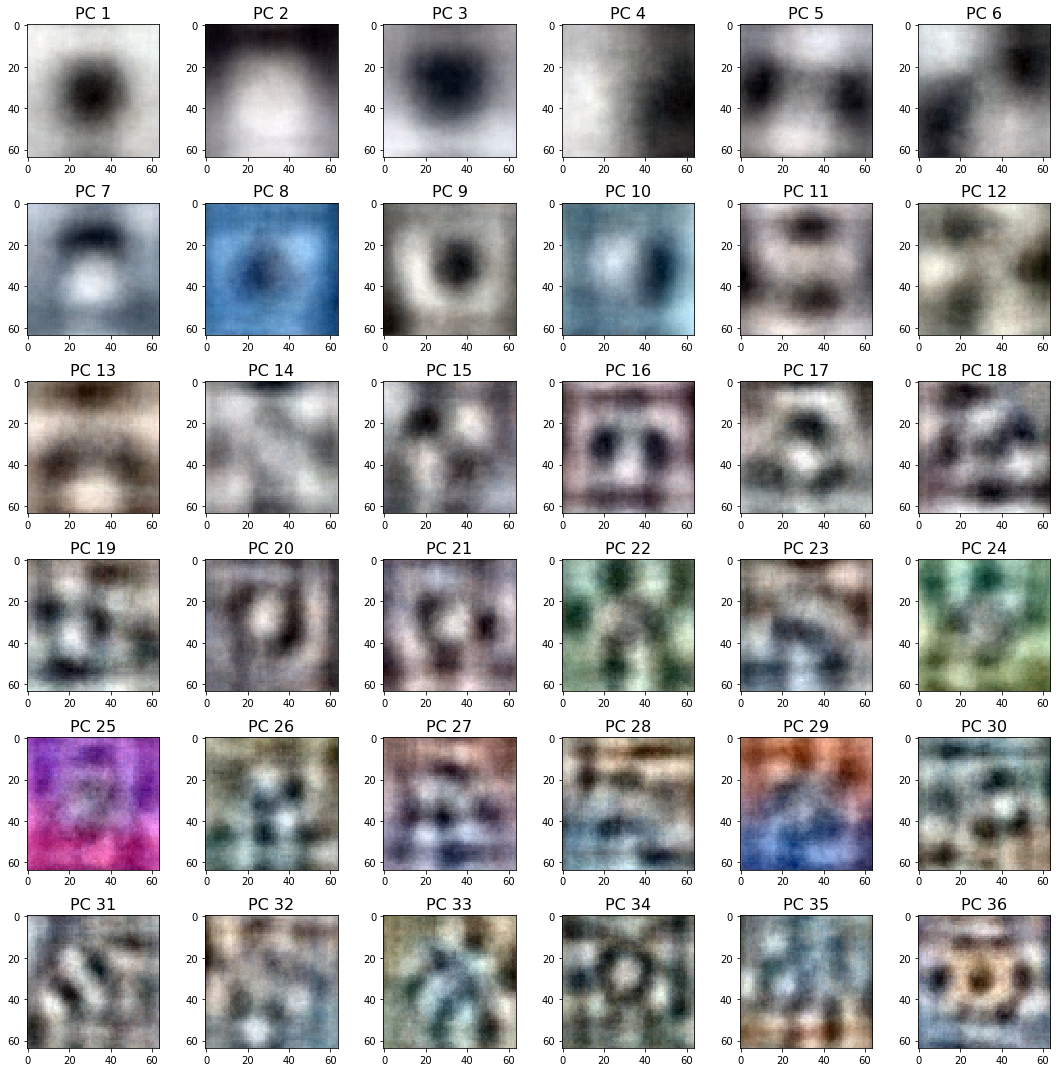

In [85]:
plt.figure(figsize=(15,15))

for i in range(36):
    plt.subplot(6,6,i+1)
    comp = PCS[i,:]
    comp = (comp - np.min(comp)) / (np.max(comp) - np.min(comp))
    plt.imshow(np.reshape(comp,(64, 64, 3)))
    plt.title('PC %s' % str(i+1), fontsize=16)

plt.tight_layout()

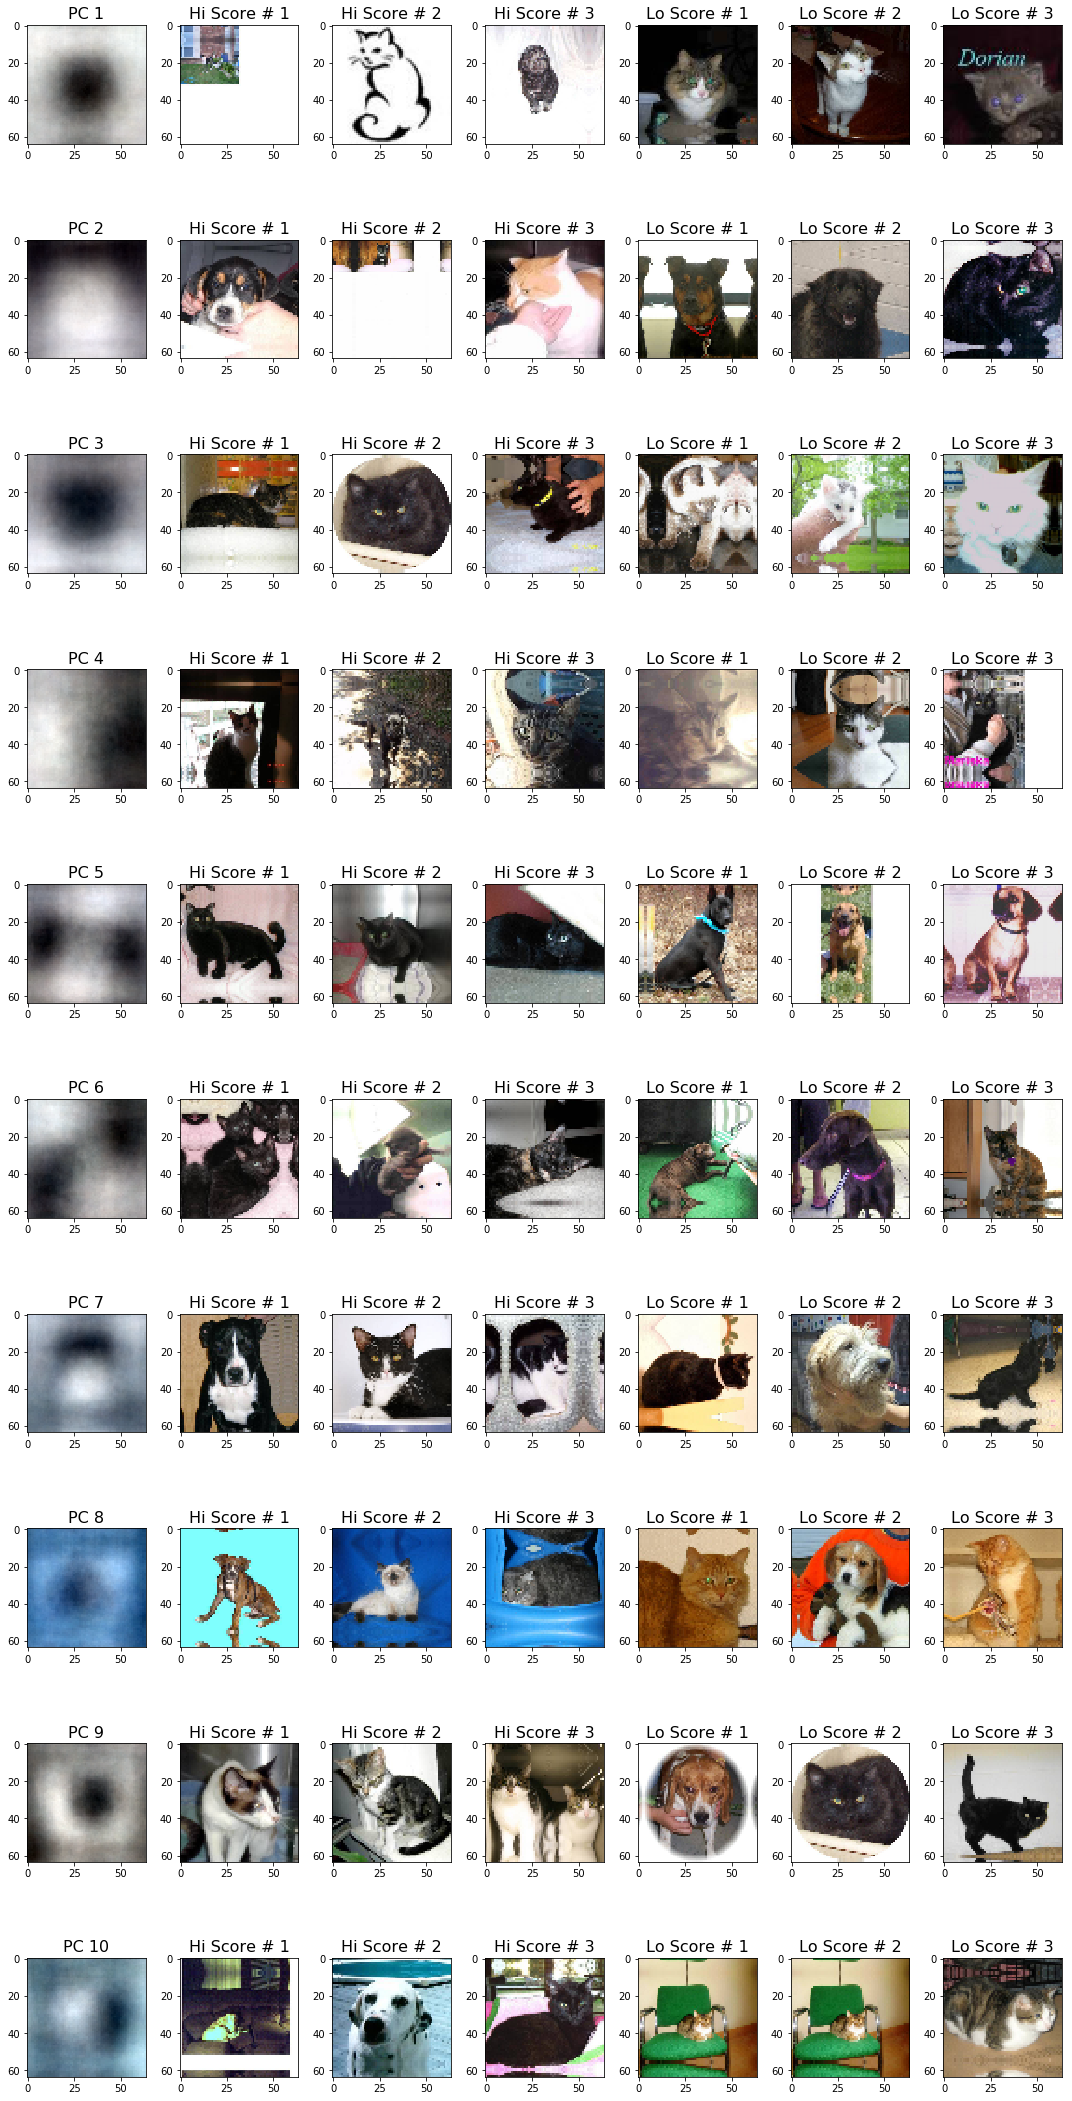

In [86]:
plt.figure(figsize=(15,30))
top_show = 3
pc_show  = 10
pltcnt = 1
for pc in range(pc_show):
    top_scoring = np.argsort(XPCA[:, pc])[-top_show:]
    bot_scoring = np.argsort(XPCA[:, pc])[top_show:]

    # Show PC
    plt.subplot(pc_show, (2*top_show)+1, pltcnt)  
    comp = PCS[pc,:]
    comp = (comp - np.min(comp)) / (np.max(comp) - np.min(comp))
    plt.imshow(np.reshape(comp, (64, 64, 3)))
    plt.title('PC %s' % str(pc+1), fontsize=16)

    pltcnt+=1
    # Show hi-scoring
    for i in range(top_show):
        plt.subplot(pc_show, (2*top_show)+1, pltcnt)    
        plt.imshow(X_train[top_scoring[i], :, :, :])
        plt.title('Hi Score # %s' % str(i+1), fontsize=16)
        pltcnt+=1
        
    for i in range(top_show):
        plt.subplot(pc_show, (2*top_show)+1, pltcnt)    
        plt.imshow(X_train[bot_scoring[i], :, :, :])
        plt.title('Lo Score # %s' % str(i+1), fontsize=16)
        pltcnt+=1        
        
plt.tight_layout()

Batch  0 ...loss =  0.0703125
Batch  10 ...loss =  0.6671875
Batch  20 ...loss =  0.6765625
Batch  30 ...loss =  0.678125
Batch  40 ...loss =  0.6859375
Batch  50 ...loss =  0.66875
Batch  60 ...loss =  0.7
Batch  70 ...loss =  0.675
Batch  80 ...loss =  0.6765625
Batch  90 ...loss =  0.6765625
             precision    recall  f1-score   support

        cat       0.55      0.55      0.55       261
        dog       0.51      0.51      0.51       239

avg / total       0.53      0.53      0.53       500



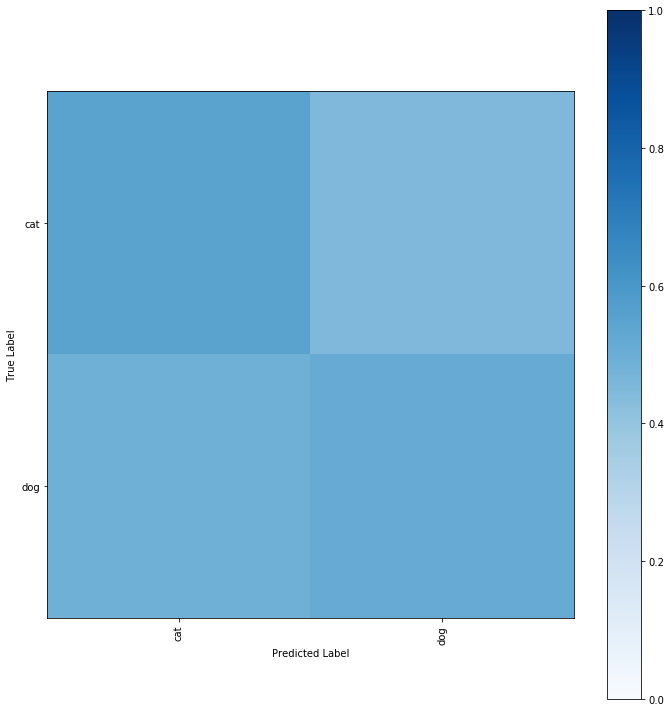

In [96]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report

batch_size = 64
batches_to_present = 100
names = ['dog', 'cat']

#--- Fit the Perceptron ---#
sgd_log = SGDClassifier(loss='hinge')

running_loss = 0
for b in range(batches_to_present):
    (Xb, yb) = get_batch(gen_train, batch_size)
    Xb = flatten(Xb)
    Xb = pca.transform(Xb)
    sgd_log.partial_fit(Xb, yb, classes=[0, 1])
    running_loss += sgd_log.score(Xb, yb) / 10
    if b % 10 == 0:
        print('Batch ', b, '...', end='')
        print('loss = ', running_loss)
        running_loss = 0

#--- Transform and predict test data ---#
ypred = sgd_log.predict(pca.transform(XFlat_test))

#--- Show results on test data ---#
print(classification_report(y_test, ypred, target_names=names))

#--- Calculate Confusion Matrix ---#
cmat = confusion_matrix(y_test, ypred).astype(np.float)
# Normalization...
for i in range(cmat.shape[0]):
    cmat[i,:] = cmat[i,:] / np.sum(cmat[i,:])
# Display...
plt.figure(figsize=(10,10))    
plt.imshow(cmat, vmin=0, vmax=1, cmap='Blues') 
plt.yticks(range(len(names)),names)
plt.xticks(range(len(names)),names,rotation='vertical')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.colorbar()
plt.tight_layout()

In [120]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.initializers import random_normal

input_dim = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

#--- Network Structure ---#
catdogNet = Sequential()

# First Convolution Block
catdogNet.add(Conv2D(32, 
                   kernel_size=(3,3), 
                   data_format='channels_last', 
                   input_shape=input_dim, 
                   activation='relu'))
catdogNet.add(Conv2D(32, 
                   kernel_size=(3,3), 
                   activation='relu'))
catdogNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Second Convolution Block
catdogNet.add(Conv2D(64, 
                   kernel_size=(3,3), 
                   activation='relu'))
catdogNet.add(Conv2D(64, 
                   kernel_size=(3,3), 
                   activation='relu'))
catdogNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Third Convolution Block
catdogNet.add(Conv2D(128, 
                   kernel_size=(3,3), 
                   activation='relu'))
catdogNet.add(Conv2D(128, 
                   kernel_size=(3,3), 
                   activation='relu'))
catdogNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

catdogNet.add(Flatten())
# To Fully Connected Layer
catdogNet.add(Dense(512, activation='relu' , kernel_initializer=random_normal(stddev=0.1)))
catdogNet.add(Dropout(0.2))

# Final Labels
catdogNet.add(Dense(2, activation='softmax'))

#--- Training ---#
# Set Parameters
catdogNet.compile(optimizer='adadelta', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

def batch_generator(gen, batch_size):  
    while 1:
        (X,y) = get_batch(gen, batch_size)
        yield (X, to_categorical(y))
        
# Run Training
train_history = catdogNet.fit_generator(batch_generator(gen_train, 32), steps_per_epoch=50, epochs=10, verbose=1)

# Save model parameters
catdogNet.save('catdogNet.h5')

Epoch 1/10
50/50 [==============================] - 29s - loss: 0.6951 - acc: 0.4981     

500/500 [==============================] - 2s     
             precision    recall  f1-score   support

        cat       0.77      0.67      0.72       261
        dog       0.69      0.78      0.73       239

avg / total       0.73      0.72      

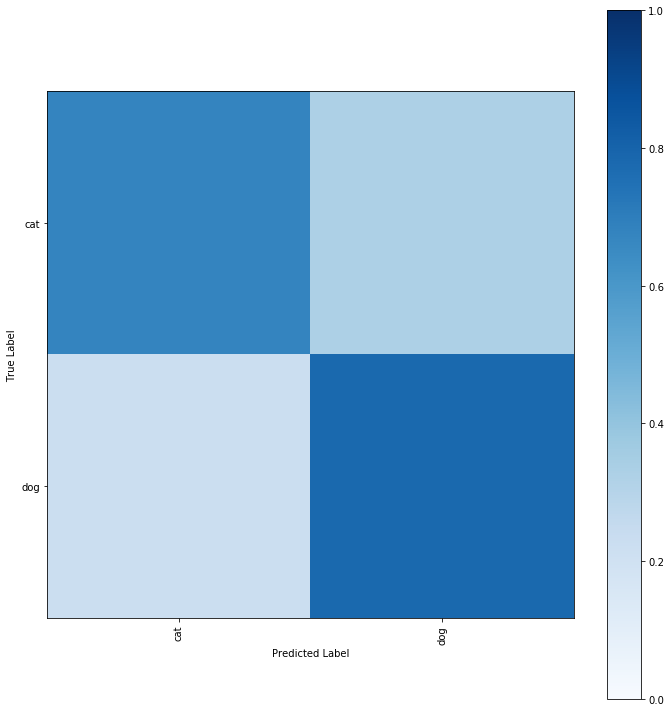

In [121]:
ypred = catdogNet.predict_classes(X_test)

#--- Show results on test data ---#
print(classification_report(y_test, ypred, target_names=names))

#--- Calculate Confusion Matrix ---#
cmat = confusion_matrix(y_test, ypred).astype(np.float)
# Normalization...
for i in range(cmat.shape[0]):
    cmat[i,:] = cmat[i,:] / np.sum(cmat[i,:])
# Display...
plt.figure(figsize=(10,10))    
plt.imshow(cmat, vmin=0, vmax=1, cmap='Blues') 
plt.yticks(range(len(names)),names)
plt.xticks(range(len(names)),names,rotation='vertical')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.colorbar()
plt.tight_layout()

/Users/eric/anaconda/envs/tf35/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


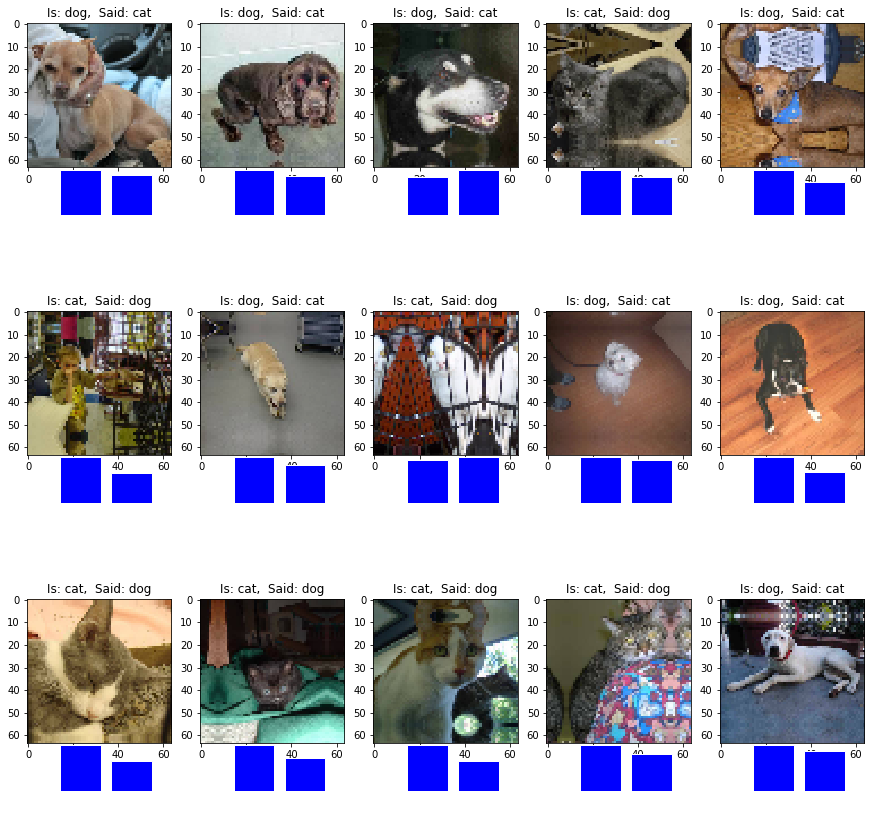

In [132]:
test_errors = np.where(np.not_equal(y_test, ypred))[0]
L = 3

names = ['dog', 'cat']
plt.figure(figsize=(15,15))
pltidx = 1

def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height],axisbg=axisbg)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

for i in range(5*L):
    test_id = test_errors[i]
    im = np.empty((1, X_test.shape[1], X_test.shape[2], X_test.shape[3]), dtype=float)
    im[0,:,:,:] = X_test[test_id, :, :, :]
    
    ax = plt.subplot(L, 5, pltidx)
    plt.imshow(X_test[test_id, :, :, :])
    plt.title('Is: %s,  Said: %s' % (names[y_test[test_id]], names[ypred[test_id]]))
    
    sax = add_subplot_axes(ax, [0.2, 0.0, 0.7, 0.2])
    sax.bar(range(2),faceNet.predict(im).ravel(), color='b', edgecolor='w')
    sax.axis('off')
    
    pltidx += 1
    